## Classification and Clustering of the Flamingo  Data set

From the exploratory analysis, the data set summary show that about 4619 user session record various number of hit_count on flamingo, with maximum value of 121 counts and minimum value of 0, which implies that some user record high hit count on flamingo in respective of the level than others. Hence, its essential to identify users who are more likely to have high hit_counts and those with low counts. In light of this, users are divided into three category with respect to the hit_counts using the median value (12) as threshold. user with hit_count greater than 12 is HighHit_count , less than 12 hit_count is LowHit_count, while user with 12 hit count are NormalHit_count.
> Pyspark Library which was bult upon spark was use for classification and clustering 

In [2]:
#Importation pyspark library 
import pyspark

In [3]:
#set the pyspark enviroment 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('classification').getOrCreate()

In [4]:
#verify the spark session 
spark 

In [6]:
#read in the clean data from the EDA analysis 
df = spark.read.csv('cmb_data.csv',header = True, inferSchema=True)
df.show(5)

+---+---------+------------+----------------+----------+-------------+
|_c0|teamLevel|platformType|count_gameclicks|count_hits|HitCount_Type|
+---+---------+------------+----------------+----------+-------------+
|  0|        1|           0|              69|         8|            1|
|  1|        1|           1|              31|         5|            1|
|  2|        1|           1|              26|         2|            1|
|  3|        1|           0|              35|         4|            1|
|  4|        1|           0|              39|         0|            1|
+---+---------+------------+----------------+----------+-------------+
only showing top 5 rows



In [7]:
#check the infomation of each column 
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- teamLevel: integer (nullable = true)
 |-- platformType: integer (nullable = true)
 |-- count_gameclicks: integer (nullable = true)
 |-- count_hits: integer (nullable = true)
 |-- HitCount_Type: integer (nullable = true)



In [8]:
#from the inspection of the table the first column look irrelevant. hence we drop the first column
df = df.drop('_c0')

## **Note**: 
> Also from the EDA analysis there exist high correlation between hitcount and GameCLick count.hence we drop count_hits and leave 
count game click since count_hits is use to deduce HitCount_Type and also both features exhibit high correlation.

In [18]:
df = df.drop('count_hits')

In [19]:
df.show(5)

+---------+------------+----------------+-------------+
|teamLevel|platformType|count_gameclicks|HitCount_Type|
+---------+------------+----------------+-------------+
|        1|           0|              69|            1|
|        1|           1|              31|            1|
|        1|           1|              26|            1|
|        1|           0|              35|            1|
|        1|           0|              39|            1|
+---------+------------+----------------+-------------+
only showing top 5 rows



In [20]:
#get the number of row 
df.count()

4619

In [22]:
train_df.show(4)

+---------+------------+----------------+-------------+
|teamLevel|platformType|count_gameclicks|HitCount_Type|
+---------+------------+----------------+-------------+
|        1|           0|               2|            1|
|        1|           0|               8|            1|
|        1|           0|              18|            1|
|        1|           0|              19|            1|
+---------+------------+----------------+-------------+
only showing top 4 rows



In [59]:
#import classification algorithm needed for the dataset
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier,DecisionTreeClassifier,NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [27]:
#set the feauters 
features_ass = VectorAssembler(inputCols = ['teamLevel','platformType','count_gameclicks'], outputCol='Select Features')
output = features_ass.transform(df)

In [29]:
#select the feature column and display the first 20 row 
output.select('Select Features').show()

+---------------+
|Select Features|
+---------------+
| [1.0,0.0,69.0]|
| [1.0,1.0,31.0]|
| [1.0,1.0,26.0]|
| [1.0,0.0,35.0]|
| [1.0,0.0,39.0]|
| [1.0,0.0,36.0]|
| [1.0,1.0,40.0]|
| [1.0,4.0,46.0]|
| [1.0,0.0,68.0]|
| [1.0,1.0,76.0]|
| [1.0,1.0,69.0]|
|[1.0,1.0,129.0]|
| [1.0,1.0,36.0]|
|[1.0,0.0,102.0]|
|[1.0,0.0,102.0]|
| [1.0,1.0,63.0]|
|[1.0,0.0,141.0]|
| [1.0,0.0,39.0]|
| [1.0,0.0,90.0]|
| [1.0,1.0,32.0]|
+---------------+
only showing top 20 rows



In [30]:
#select the needed column from the transformed data 
class_data = output.select('Select Features','HitCount_Type')

In [32]:
#display the first 5
class_data.show(5)

+---------------+-------------+
|Select Features|HitCount_Type|
+---------------+-------------+
| [1.0,0.0,69.0]|            1|
| [1.0,1.0,31.0]|            1|
| [1.0,1.0,26.0]|            1|
| [1.0,0.0,35.0]|            1|
| [1.0,0.0,39.0]|            1|
+---------------+-------------+
only showing top 5 rows



In [33]:
#split the dataset into training and test
train_df, test_df = class_data.randomSplit([0.75,0.25])
print('Lenght of Train_data:', train_df.count())
print('Lenght of Test_data:', test_df.count())

Lenght of Train_data: 3484
Lenght of Test_data: 1135


## **Random Forest Model**

In [35]:
#set_up the RandomForest_Model
rf = RandomForestClassifier(labelCol="HitCount_Type", featuresCol="Select Features", numTrees=20)
#model it on the train data 
model = rf.fit(train_df)

In [36]:
#prediction 
pred = model.transform(test_df)

In [37]:
pred.printSchema()

root
 |-- Select Features: vector (nullable = true)
 |-- HitCount_Type: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [41]:
#display the prediction value 
pred.select('prediction','HitCount_Type').show(5)

+----------+-------------+
|prediction|HitCount_Type|
+----------+-------------+
|       1.0|            1|
|       1.0|            1|
|       1.0|            1|
|       1.0|            1|
|       1.0|            1|
+----------+-------------+
only showing top 5 rows



In [43]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="HitCount_Type", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.179736


In [44]:
accuracy

0.8202643171806168

## **Navie Bayes**

In [52]:
#set up the NavieBases Model 
NB = NaiveBayes(featuresCol='Select Features',labelCol='HitCount_Type',smoothing=5.0)
#fit the model
model2 = NB.fit(train_df)

In [53]:
#prediction 
pred2 = model2.transform(test_df)

In [54]:
#display the prediction value 
pred2.select('prediction','HitCount_Type').show(20)

+----------+-------------+
|prediction|HitCount_Type|
+----------+-------------+
|       1.0|            1|
|       1.0|            1|
|       0.0|            1|
|       0.0|            1|
|       0.0|            1|
|       0.0|            1|
|       0.0|            1|
|       0.0|            1|
|       0.0|            1|
|       0.0|            1|
|       0.0|            1|
|       0.0|            2|
|       0.0|            1|
|       0.0|            1|
|       0.0|            0|
|       0.0|            1|
|       0.0|            0|
|       0.0|            1|
|       0.0|            1|
|       0.0|            0|
+----------+-------------+
only showing top 20 rows



In [57]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="HitCount_Type", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred2)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.282819


In [58]:
accuracy

0.7171806167400882

## **Decision tree classifier**

In [62]:
#set GBT classifier model 
DT = DecisionTreeClassifier(featuresCol='Select Features',labelCol='HitCount_Type')
#fit the model into train data set
model3 = DT.fit(train_df)

In [63]:
#prediction 
pred3 = model3.transform(test_df)

In [64]:
#display the prediction value 
pred3.select('prediction','HitCount_Type').show(20)

+----------+-------------+
|prediction|HitCount_Type|
+----------+-------------+
|       1.0|            1|
|       1.0|            1|
|       1.0|            1|
|       1.0|            1|
|       1.0|            1|
|       1.0|            1|
|       1.0|            1|
|       1.0|            1|
|       1.0|            1|
|       1.0|            1|
|       1.0|            1|
|       1.0|            2|
|       1.0|            1|
|       1.0|            1|
|       1.0|            0|
|       1.0|            1|
|       1.0|            0|
|       1.0|            1|
|       1.0|            1|
|       0.0|            0|
+----------+-------------+
only showing top 20 rows



In [65]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="HitCount_Type", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred3)
print("Test Error = %g" % (1.0 - accuracy));
print (accuracy)

Test Error = 0.178855
0.8211453744493392


## **Clustering Analysis**
This section describes the use of unsupervised learning algorithm to group the data set into similar categories, this study adopts
k-Means clustering. Below are the following task carried out:
- importing of library
- import the data set 
- group the data into features
- scale the data set 
- set up the model 

In [106]:
#libraries 
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.linalg import DenseVector
from numpy import array

In [68]:
#read in the data set 
clus = spark.read.csv('cmb_data.csv',header=True,inferSchema=True)
clus.show(5)

+---+---------+------------+----------------+----------+-------------+
|_c0|teamLevel|platformType|count_gameclicks|count_hits|HitCount_Type|
+---+---------+------------+----------------+----------+-------------+
|  0|        1|           0|              69|         8|            1|
|  1|        1|           1|              31|         5|            1|
|  2|        1|           1|              26|         2|            1|
|  3|        1|           0|              35|         4|            1|
|  4|        1|           0|              39|         0|            1|
+---+---------+------------+----------------+----------+-------------+
only showing top 5 rows



**Note**:
The experience level of the user can also influence the hitCount, so the study adopt clustering technique on top of classification algorithm previous carried out to catagorize the user based on experinence which is measure by the game level. there column platformType has no significant influence on the feature.

In [69]:
clus = clus.drop('_c0','platformType')

In [70]:
clus.show(3)

+---------+----------------+----------+-------------+
|teamLevel|count_gameclicks|count_hits|HitCount_Type|
+---------+----------------+----------+-------------+
|        1|              69|         8|            1|
|        1|              31|         5|            1|
|        1|              26|         2|            1|
+---------+----------------+----------+-------------+
only showing top 3 rows



In [73]:
#group by features 
feat = ['teamLevel','count_gameclicks','count_hits','HitCount_Type']
feat_cols = VectorAssembler(inputCols=feat,outputCol='sel_feat')
ft_data=feat_cols.transform(clus)

In [74]:
ft_data.show(3)

+---------+----------------+----------+-------------+------------------+
|teamLevel|count_gameclicks|count_hits|HitCount_Type|          sel_feat|
+---------+----------------+----------+-------------+------------------+
|        1|              69|         8|            1|[1.0,69.0,8.0,1.0]|
|        1|              31|         5|            1|[1.0,31.0,5.0,1.0]|
|        1|              26|         2|            1|[1.0,26.0,2.0,1.0]|
+---------+----------------+----------+-------------+------------------+
only showing top 3 rows



In [75]:
final_dt = ft_data.select('sel_feat')

In [76]:
final_dt.show(2)

+------------------+
|          sel_feat|
+------------------+
|[1.0,69.0,8.0,1.0]|
|[1.0,31.0,5.0,1.0]|
+------------------+
only showing top 2 rows



In [136]:
#scale the Data set 
scale = StandardScaler(inputCol='sel_feat',outputCol='features',withMean=True,withStd=True)
smodel = scale.fit(final_dt)
clus_dt = smodel.transform(final_dt)

In [137]:
clus_dt.show(4)

+------------------+--------------------+
|          sel_feat|            features|
+------------------+--------------------+
|[1.0,69.0,8.0,1.0]|[-1.7435288565423...|
|[1.0,31.0,5.0,1.0]|[-1.7435288565423...|
|[1.0,26.0,2.0,1.0]|[-1.7435288565423...|
|[1.0,35.0,4.0,1.0]|[-1.7435288565423...|
+------------------+--------------------+
only showing top 4 rows



In [88]:
#set_up the model
km2 = KMeans(featuresCol='Sfeature', maxIter=100)
km3 = KMeans(featuresCol='Sfeature',k = 3, maxIter=100)

In [89]:
#fit the model 
model_k2 = km2.fit(clus_dt)
model_k3 = km3.fit(clus_dt)

In [93]:
#within sum of square 
wss_k2 = model_k2.summary.trainingCost
wss_k3 = model_k3.summary.trainingCost

In [110]:
def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection   = featuresAndPrediction.rdd.map(array)

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)
def elbow(elbowset, clusters):
	wsseList = []	
	for k in clusters:
		print("Training for cluster size {} ".format(k))
		kmeans = KMeans(featuresCol='Sfeature',k = k, seed = 1)
		model = kmeans.fit(clus_dt)
		transformed = model.transform(clus_dt)
		featuresAndPrediction = transformed.select("Sfeature", "prediction")

		W = model.summary.trainingCost
		print("......................WSSE = {} ".format(W))

		wsseList.append(W)
	return wsseList

def elbow_plot(wsseList, clusters):
	wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
	wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

def parallel_plot(data, P):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(P)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')


In [114]:
cluster = range(2,10)
#featur = clus_dt.select('Sfeature')
wsse_list = elbow(clus_dt,cluster)

Training for cluster size 2 
......................WSSE = 10955.519332678241 
Training for cluster size 3 
......................WSSE = 7175.625230835749 
Training for cluster size 4 
......................WSSE = 5112.251805279729 
Training for cluster size 5 
......................WSSE = 4566.01867083082 
Training for cluster size 6 
......................WSSE = 3462.91707892981 
Training for cluster size 7 
......................WSSE = 3119.114485287003 
Training for cluster size 8 
......................WSSE = 2435.7330819535446 
Training for cluster size 9 
......................WSSE = 2164.647171312163 


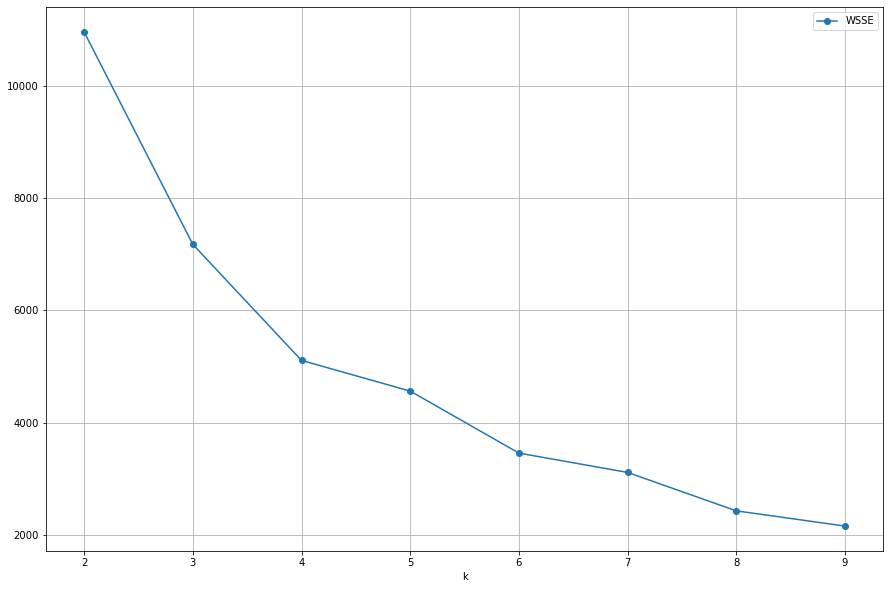

In [116]:
elbow_plot(wsse_list, cluster)

Note: the elbow join: 4

In [133]:
clus_dt = clus_dt.select('Sfeature')

In [138]:
# Trains a k-means model.
km4 = KMeans().setK(4).setSeed(1)
model_k4 = km4.fit(clus_dt)

# Make predictions
predictions = model_k4.transform(clus_dt)

In [139]:
#model Evaluation 
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.6107146418984036


In [140]:
#Shows the result.
centers = model_k4.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-0.64534343  2.72276704  2.68485062 -0.99535609]
[ 0.63205627 -0.49396818 -0.56872983  0.91258538]
[-1.23057925 -0.5969682  -0.63686307  0.73991893]
[ 0.30914693  0.21674471  0.31013627 -0.99535609]
